## Visualize the inverse model

Evaluate and visualize the performance of the environment model by seeing it visualize future states while a A2C agent plays the game.

In [1]:
#Don't use the GPU for these runs:
import os 
os.environ["CUDA_VISIBLE_DEVICES"]=""

import numpy as np
import tensorflow as tf
from env_model_minigrid import make_env, create_env_model, create_latentinverse_env_model
from common.multiprocessing_env import SubprocVecEnv
from common.minigrid_util import num_pixels, mode_rewards, pix_to_target, rewards_to_target
from a2c import get_actor_critic, CnnPolicy
from i2a import convert_target_to_real
import gym
import gym_minigrid
import common.minigrid_util

In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2

Next create the environments we will use.

In [3]:
env_name = "MiniGrid-Blocks-6x6-v0"
#env_name = "MiniGrid-Blocks-8x8-v0"
#env_name = "MiniGrid-Blocks-16x16-v0"
nenvs = 16
nsteps = 5
envs = [make_env(env_name) for i in range(nenvs)]
envs = SubprocVecEnv(envs)

ob_space = envs.observation_space.shape
ac_space = envs.action_space
num_actions = envs.action_space.n

Finally, go ahead and test the environment model in minigrid. This will use the A2C agent to play the game and the environment model to predict future states and rewards. This will visualize the imagined and real rewards and game states from the environment model. 

In [4]:
#Make minigrid env...
env = gym_minigrid.wrappers.ImgObsWrapper(gym.make(env_name))

done = False
states = env.reset()
num_actions = ac_space.n
nw, nh, nc = ob_space
print('observation space', ob_space)
print('number of actions', num_actions)

observation space (6, 6, 3)
number of actions 5


In [5]:
states.shape

(6, 6, 3)

In [6]:
tf.reset_default_graph()
n_steps = 20
pred_actions = np.zeros((n_steps, num_actions))
act_states = np.zeros((n_steps, nw, nh, nc))
act_rewards = np.zeros(n_steps)
act_actions = np.zeros(n_steps)
steps = 0
with tf.Session() as sess:
    # Load the actor
    with tf.variable_scope('actor'):
        actor_critic = get_actor_critic(sess, nenvs, nsteps, ob_space,
                ac_space, CnnPolicy, should_summary=False)
    #actor_critic.load('weights/a2c_100000.ckpt')
    actor_critic.load('weights/a2c_400000.ckpt')

    # Load the critic
    with tf.variable_scope('env_model'):
        env_model = create_latentinverse_env_model(ob_space, num_actions, num_pixels,
                len(mode_rewards['regular']), should_summary=False)
        #env_model = create_env_model(ob_space, num_actions, num_pixels,
        #        len(mode_rewards['regular']), should_summary=False)

    save_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='env_model')
    loader = tf.train.Saver(var_list=save_vars)
    loader.restore(sess, 'weights/env_model_inverse.ckpt')
    
    #while not done and steps < n_steps:
    while steps < n_steps:
        actions, _, _ = actor_critic.act(np.expand_dims(states, axis=0))
        onehot_actions = np.zeros((1, num_actions))
        onehot_actions[range(1), actions] = 1
        next_states, reward, done, _ = env.step(actions[0])
        ainv = sess.run([env_model.ainvprobs], 
                                       feed_dict={
                env_model.input_states: np.expand_dims(states, axis=0),
                env_model.target_states: np.expand_dims(next_states, axis = 0)
            })
        print("Step: %d, Reward: %f"%(steps, reward))
        pred_actions[steps,:] = ainv[0]
        act_actions[steps] = actions
        act_states[steps,:,:,:] = states
        act_rewards[steps] = reward
        states = next_states
        steps += 1


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
INFO:tensorflow:Restoring parameters from weights/a2c_400000.ckpt
Instructions for updating:
dim is deprecated, use axis instead
INFO:tensorflow:Restoring parameters from weights/env_model_inverse.ckpt
Step: 0, Reward: -0.006944
Step: 1, Reward: -0.006944
Step: 2, Reward: -0.006944
Step: 3, Reward: -0.006944
Step: 4, Reward: -0.006944
Step: 5, Reward: -0.006944
Step: 6, Reward: -0.006944
Step: 7, Reward: -0.006944
Step: 8, Reward: -0.006944
Step: 9, Reward: -0.006944
Step: 10, Reward: -0.006944
Step: 11, Reward: -0.006944
Step: 12, Reward: -0.006944
Step: 13, Reward: -0.006944
Step: 14, Reward: -0.006944
Step: 15, Reward: -0.006944
Step: 16, Reward: 1.000

In [7]:
act_actions

array([3., 3., 0., 3., 0., 1., 1., 0., 4., 4., 4., 2., 1., 4., 2., 1., 0.,
       4., 3., 2.])

In [8]:
np.argmax(pred_actions, 1)

array([3, 3, 0, 3, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 2, 1, 0, 0, 0, 2])

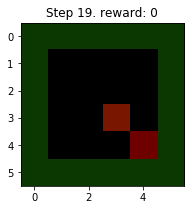

In [11]:
#Visualize...
#If it goes blank then reached the done state
for steps in range(n_steps):
    clear_output(True)
    plt.figure(figsize=(10,3))        
    plt.title("Step %d. reward: %i" % (steps,act_rewards[steps]))
    plt.imshow(act_states[steps,:,:,:]*11./255)
    plt.show()
    time.sleep(2)

In [ ]:
#Seems better. Only one glitch in the model. The agent appears to overlap with the block on one frame, 
#or the agent just disappears. Thus:
#Imagination doesn't contain the agent all the time....
#X and Y dynamics now appear fixed... 

#There's still something funny with the dynamics when it interacts with the block. 
#...x and y must still be switched somewhere.

In [ ]:
#Todo:

#Try out larger environments then what agent is trained on
#Try out only learning latent representation
# xx Test inverse model

#Code framework for Obs RL:
## Change I2A algorithm to:
### a) take off-line state transitions -- generated from:
###    i) A random agent
###    ii) Many random agents
###    iii) Ghost conditions
### b) Replace actual action with a sample from the inverse model. Rest of algorithm is the same.

## Implement test environment. Compare with:
### Naive algorithm with no obs experience
### Expert algorithm with 'on policy' experience from obs phase
### RILO (if can find code...)

#Meta learner instead?